#                  Who's the Winner of the African Cup of Nations AFCON2022?

<h3 style="color: blue;">Input Datasets :</h3>
<p>We will need three datasets in our analysis: 
<p>1st one: FIFA world rankings from 1992 to 2021, it contains the FIFA rankings of all football nation teams from all over the world, from which we will extract the ranking of teams that will be playing in AFCON2022.
<p>2nd one: For this one, we didn't find one online, so we decided to create our own dataset using excel. It contains all the AFCON2022 fixtures in order.
<p>3rd one: International Soccer matches from 1872 to 2021, from which we extract only matches that occurred between african nation teams.

<h3 style="color: blue;">Libraries :</h3>
<p>Let's begin by importing the needed classes. </p>

In [958]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

<h1 style="color: blue;">Exploring and Cleaning of data</h1>

<h3 style="color: DodgerBlue;">First Datatset</h3>
<p>Only five columns are necessary for our analysis. Therefore, the ranking variable contains only these five attributs for every country in the dataset, we filter then countries from outside the African continent and we convert the date to the datetime format which is a comparable type. </p>

In [952]:
rankings = pd.read_excel('/Users/admin/Downloads/fifa_ranking-2021-05-27-3.xlsx')


rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'rank_date', 'confederation']]

rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
rankings = rankings.drop(rankings[rankings['confederation']!= 'CAF'].index)
rankings.head()

,rank,country_full,country_abrv,rank_date,confederation
1,107,Mozambique,MOZ,1992-12-31,CAF
5,111,Sudan,SDN,1992-12-31,CAF
6,112,Mauritius,MRI,1992-12-31,CAF
11,117,Guinea-Bissau,GNB,1992-12-31,CAF
19,104,Swaziland,SWZ,1992-12-31,CAF


<h3 style="color: DodgerBlue;">Second Datatset</h3>
<p>Identically, we extract here only useful informations about African teams and the groups they will playing in during the African cup, and then we drop eventual rows with no single significant value. </p>

In [926]:
african_cup = pd.read_excel('/Users/admin/Desktop/AFCON-2021-Dataset-excel.xlsx')

african_cup = african_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
african_cup = african_cup.dropna(how='all')
african_cup = african_cup.set_index('Team')
african_cup.head()

,Group,First match \nagainst,Second match\n against,Third match\n against
Team,,,,
Cameroon,A,Burkina Faso,Ethiopia,Cabo Verde
Burkina Faso,A,Cameroon,Cabo Verde,Burkina Faso
Ethiopia,A,Cabo Verde,Cameroon,Ethiopia
Cabo Verde,A,Ethiopia,Burkina Faso,Cameroon
Senegal,B,Zimbabwe,Guinea,Malawi


<h3 style="color: DodgerBlue;">Third Datatset</h3>
<p>In this database, we will only restrict ourselves to matches that occured after 2011, the reason behind that is that teams can change completely from time to time, which means that including matches from more than 10 years ago may reduce the accuracy of predictions. </p>

In [916]:
matches = pd.read_csv('/Users/admin/Downloads/Match_results/results.csv')
matches['date'] = pd.to_datetime(matches['date'])
matches=matches[matches['date']>'2011-01-01']
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
32836,2011-01-02,Iran,Angola,1.0,0.0,Friendly,Doha,Qatar,True
32837,2011-01-02,Iraq,China PR,2.0,3.0,Friendly,Doha,Qatar,True
32838,2011-01-02,Jordan,Uzbekistan,2.0,2.0,Friendly,Dubai,United Arab Emirates,True
32839,2011-01-02,United Arab Emirates,Syria,2.0,0.0,Friendly,Al Ain,United Arab Emirates,False
32840,2011-01-04,Bahrain,North Korea,0.0,1.0,Friendly,Riffa,Bahrain,False


<h3 style="color: DodgerBlue;">Merge of datasets: </h3>
<p>in order to gather datas in one dataset, we did a merge between rankings and matches to have in each row of matches all the details, including the current ranking in that time, about the home and away teams as well as the statistics in the end of the match. </p>

In [917]:
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()


# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

matches = matches.loc[:,~matches.columns.duplicated()] #eliminate duplicated columns
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,confederation_home,rank_date_away,rank_away,country_full_away,country_abrv_away,confederation_away
0,2011-01-05,Egypt,Tanzania,5.0,1.0,Nile Basin Tournament,Cairo,Egypt,False,2011-01-05,9.0,Egypt,EGY,CAF,2011-01-05,116.0,Tanzania,TAN,CAF
1,2011-01-05,Kenya,Sudan,1.0,0.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-05,120.0,Kenya,KEN,CAF,2011-01-05,96.0,Sudan,SDN,CAF
2,2011-01-05,Uganda,Burundi,3.0,1.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-05,80.0,Uganda,UGA,CAF,2011-01-05,128.0,Burundi,BDI,CAF
3,2011-01-08,Egypt,Uganda,1.0,0.0,Nile Basin Tournament,Cairo,Egypt,False,2011-01-08,9.0,Egypt,EGY,CAF,2011-01-08,80.0,Uganda,UGA,CAF
4,2011-01-08,Tanzania,Burundi,1.0,1.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-08,116.0,Tanzania,TAN,CAF,2011-01-08,128.0,Burundi,BDI,CAF


<h3 style="color: DodgerBlue;">Exploratory of data: </h3>
<p>There are few questions in order to understand data better

Here, we decided to draw a pie that shows the distribution of wins, losses and draws for the home team. With a rate of approximately 50%, it is clear that the home team is always more likely to win the match. For the host team, a draw is also considered as a loss and it is never a satisfying result. Hence, we took the idea of giving the hosted team a little advantage by considering it as a winner in case of equal probabilities or probability in the limit of the interval of draw, espicially in elimination rounds. </p>

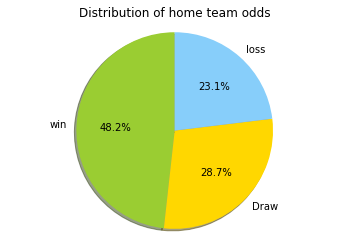

In [940]:
labels = 'win', 'Draw', 'loss'
colors = ['yellowgreen', 'gold', 'lightskyblue']

x = len(matches[matches['score_difference'] > 0])
y = len(matches[matches['score_difference'] == 0])
z = len(matches[matches['score_difference'] < 0])
L=[x,y,z]
plt.pie(L, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Distribution of home team odds')

plt.show()

In [918]:
#adding some relevant parameters to matches 

matches['rank_difference'] = matches['rank_home'] - matches['rank_away']

matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = (matches['score_difference'] > 0)*1 # take draw as lost
matches['is_loss'] = (matches['score_difference'] <= 0)*1 
matches['is_stake'] = matches['tournament'] != 'Friendly'
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,confederation_home,rank_date_away,rank_away,country_full_away,country_abrv_away,confederation_away,rank_difference,average_rank,score_difference,is_won,is_loss,is_stake
0,2011-01-05,Egypt,Tanzania,5.0,1.0,Nile Basin Tournament,Cairo,Egypt,False,2011-01-05,9.0,Egypt,EGY,CAF,2011-01-05,116.0,Tanzania,TAN,CAF,-107.0,62.5,4.0,1,0,True
1,2011-01-05,Kenya,Sudan,1.0,0.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-05,120.0,Kenya,KEN,CAF,2011-01-05,96.0,Sudan,SDN,CAF,24.0,108.0,1.0,1,0,True
2,2011-01-05,Uganda,Burundi,3.0,1.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-05,80.0,Uganda,UGA,CAF,2011-01-05,128.0,Burundi,BDI,CAF,-48.0,104.0,2.0,1,0,True
3,2011-01-08,Egypt,Uganda,1.0,0.0,Nile Basin Tournament,Cairo,Egypt,False,2011-01-08,9.0,Egypt,EGY,CAF,2011-01-08,80.0,Uganda,UGA,CAF,-71.0,44.5,1.0,1,0,True
4,2011-01-08,Tanzania,Burundi,1.0,1.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-08,116.0,Tanzania,TAN,CAF,2011-01-08,128.0,Burundi,BDI,CAF,-12.0,122.0,0.0,0,1,True


<h3 style="color: DodgerBlue;">Analysis of the new features: </h3>
<p>The rate of winning for the home team when it's better ranked is 33%, which is not that far from the previous rate, this shows that the FIFA rankings could give a first idea about the winning team knowing that there is some exceptions represented by the rest 15%. 
<p>This strengthen also the fact that the home team have more chances to win even if it's less ranked or less favorite before.</p>

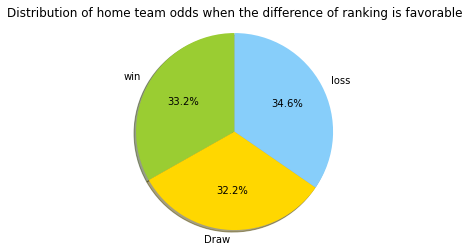

In [942]:
labels = 'win', 'Draw', 'loss'
colors = ['yellowgreen', 'gold', 'lightskyblue']

Match_pos_rank_diff = matches[matches['rank_difference'] > 0]

win = len(Match_pos_rank_diff[Match_pos_rank_diff['score_difference'] > 0])
draw = len(Match_pos_rank_diff[Match_pos_rank_diff['score_difference'] == 0])
loss = len(Match_pos_rank_diff[Match_pos_rank_diff['score_difference'] < 0])
L=[win,draw,loss]
plt.pie(L, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Distribution of home team odds when the difference of ranking is favorable')

plt.show()

In [919]:
#adding historic results for every confrontation (wins - Losses) of the home team

matches['Previouswins_home'] = matches.apply(
    lambda x: matches[(matches.home_team == x.home_team) & 
                      (matches.away_team == x.away_team) & 
                      (matches.date < x.date)].is_won.sum() + 
             matches[(matches.away_team == x.home_team) & 
                      (matches.home_team == x.away_team) & 
                      (matches.date < x.date)].is_loss.sum(), axis=1)
matches['Previouswins_away'] = matches.apply(
    lambda x: matches[(matches.home_team == x.home_team) & 
                      (matches.away_team == x.away_team) & 
                      (matches.date < x.date)].is_loss.sum() + 
             matches[(matches.away_team == x.home_team) & 
                      (matches.home_team == x.away_team) & 
                      (matches.date < x.date)].is_won.sum(), axis=1)


matches['history_teams'] = matches['Previouswins_home'] - matches['Previouswins_away']
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,confederation_home,rank_date_away,rank_away,country_full_away,country_abrv_away,confederation_away,rank_difference,average_rank,score_difference,is_won,is_loss,is_stake,Previouswins_home,Previouswins_away,history_teams
0,2011-01-05,Egypt,Tanzania,5.0,1.0,Nile Basin Tournament,Cairo,Egypt,False,2011-01-05,9.0,Egypt,EGY,CAF,2011-01-05,116.0,Tanzania,TAN,CAF,-107.0,62.5,4.0,1,0,True,0,0,0
1,2011-01-05,Kenya,Sudan,1.0,0.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-05,120.0,Kenya,KEN,CAF,2011-01-05,96.0,Sudan,SDN,CAF,24.0,108.0,1.0,1,0,True,0,0,0
2,2011-01-05,Uganda,Burundi,3.0,1.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-05,80.0,Uganda,UGA,CAF,2011-01-05,128.0,Burundi,BDI,CAF,-48.0,104.0,2.0,1,0,True,0,0,0
3,2011-01-08,Egypt,Uganda,1.0,0.0,Nile Basin Tournament,Cairo,Egypt,False,2011-01-08,9.0,Egypt,EGY,CAF,2011-01-08,80.0,Uganda,UGA,CAF,-71.0,44.5,1.0,1,0,True,0,0,0
4,2011-01-08,Tanzania,Burundi,1.0,1.0,Nile Basin Tournament,Cairo,Egypt,True,2011-01-08,116.0,Tanzania,TAN,CAF,2011-01-08,128.0,Burundi,BDI,CAF,-12.0,122.0,0.0,0,1,True,0,0,0


<h3 style="color: DodgerBlue;">Analysis of history_team feature: </h3>
<p>The rate of winning for the home team when it's better favored by history is 56%, which shows that the reality is often loyal to the history in terms of team powers when facing each other.
<p>Head-to-head history results have shown that they are a good factor to be taken into account when predicting final winner of a given match.</p>

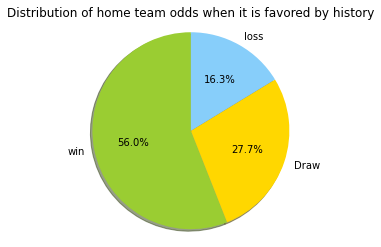

In [943]:
labels = 'win', 'Draw', 'loss'
colors = ['yellowgreen', 'gold', 'lightskyblue']

Match_pos_rank_diff = matches[matches['history_teams'] > 0]

win = len(Match_pos_rank_diff[Match_pos_rank_diff['score_difference'] > 0])
draw = len(Match_pos_rank_diff[Match_pos_rank_diff['score_difference'] == 0])
loss = len(Match_pos_rank_diff[Match_pos_rank_diff['score_difference'] < 0])
L=[win,draw,loss]
plt.pie(L, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Distribution of home team odds when it is favored by history')

plt.show()

<h1 style="color: blue;">Preprocessing and Classification : </h1>
<h3 style="color: DodgerBlue;">Comparison between classifiers: </h3>
<p> Knowing that there are a lot of algorithms of classification, we have chosen to compare a couple of the famous ones in term of prediction accuracy. The result shows that the logistic regression is more  reliable to determine who is the winner of matches. </p>

Running Random Forest
Running Logistic Regression
Running Decision Tree


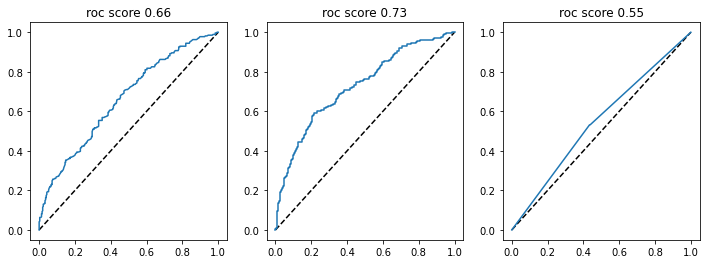

In [920]:
#comparison between classifiers

train_X, train_y = matches.loc[:,['average_rank', 'rank_difference', 'is_stake','history_teams']], matches['is_won']
classifiers = {'Random Forest': RandomForestClassifier(n_estimators=300),
              'Logistic Regression': LogisticRegression(C=1e-5, max_iter=200),
               'Decision Tree' : DecisionTreeClassifier()
              }
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)

fig = plt.figure(figsize=[12, 4])
for i, (name, clf) in enumerate(classifiers.items()):
    print('Running', name)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    # plot
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    ax.set_title('roc score {0:.2f}'.format(roc_auc_score(y_test, y_pred)))

<p> The figures show that the logistic regression is the more accurate algorithm of classification for our model. In fact, logistic regression predicts correctly with an accuracy of 70%

<h3 style="color: DodgerBlue;">Modeling: </h3>
<p> The logistic regression is the more powerful algorithm of classification. Hence, we choosed to use it in the rest of our analysis. </p>
<h3 style="color: DodgerBlue;">Preprocessing of data and Training of the model: </h3>
<p> Here, the preprocessing consists of a polynomial feature method, the result is a new feature matrix containing a 2-degree polynomial combination of input features. Then, we will train our model with a training set with a size of 80% out of the original dataset. 
<h3 style="color: DodgerBlue;">Accuracy Metrics: </h3>
<h4 style="color: purple;">ROC score: </h4>
<p> The ROC score of logistic regression is not constant. In fact, it changes every time we train the model. This time, it's equal 68% which is good knowing that soccer matches can not be perfectly predictable since they are only few goals scored in a single match. 
<h4 style="color: purple;">Confusion Matrix on training and testing sets: </h4>
<p> The confusion matrix is a way of comparing predictions with reality. In our model, 1 means a win for the home team whereas a 0 means a loss. The colors in the confusion matrix are more darker when the rate is more bigger. In our case, colors are more darker in the matching areas between prediction and reality with a little darkness in the testing set due to its smaller size comparing to the training set. Hence, our model is doing its job perfectly.

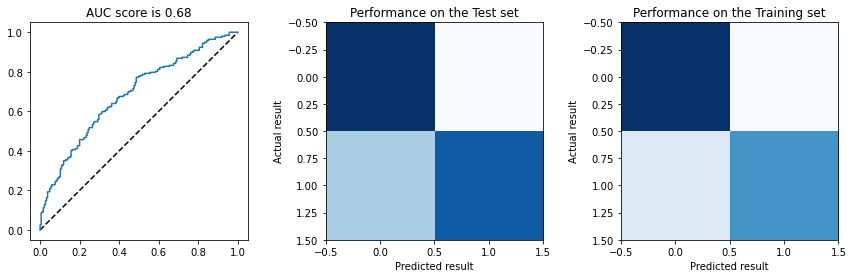

In [945]:
#Training of the Classification algorithm and plot of the accuracy score with confusion matrices

X, y = matches.loc[:,['average_rank', 'rank_difference', 'is_stake','history_teams']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


logreg = linear_model.LogisticRegression(C=1e-5, max_iter=200)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
                ])
model = model.fit(X_train, y_train)
model.score(X_test, y_test)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues') 

ax.set_xlabel('Predicted result')
ax.set_ylabel('Actual result')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues') 
ax.set_xlabel('Predicted result')
ax.set_ylabel('Actual result')
ax.set_title('Performance on the Training set')
pass

<h4 style="color: purple;">Bad predictions: </h4>
<p> To know the source of our mistakes, we tried to look at the bad predictions, to see the distribution of not friendly match in those bad predictions and after overall. We noticed that the official matches are more likely to lead to a wrong prediction, this shows that teams play more roughly in official games. Particularly, this can be explained by the fact that official competition are often organised in a one country, so there is no home or away team besides the host one. 

Stakes distribution in the wrong predictions
True     0.65942
False    0.34058
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.737284
False    0.262716
Name: is_stake, dtype: float64


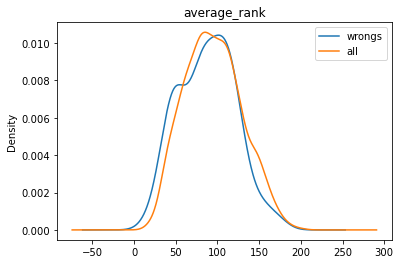

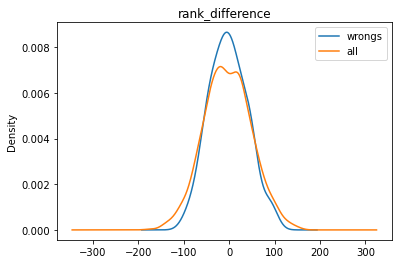

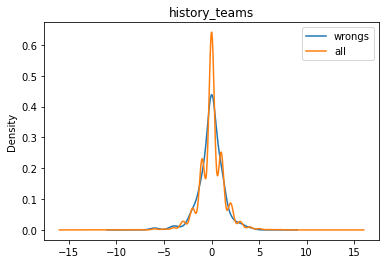

In [946]:
features = ['average_rank', 'rank_difference', 'history_teams']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])


These figures show that we're correctly predicting:
1. in case of distant ranks.
2. in case of big rank difference.
3. in case of significatif history_teams value.

<h2 style="color: blue;">Simulation of African cup 2022 matches results:</h2>
   

<h3 style="color: DodgerBlue;">Group Stage: </h3>
<p>   Let's try to predict the results of group stage matches

In [949]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

african_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(african_cup.index.unique())]
african_cup_rankings = african_cup_rankings.set_index(['country_full'])
african_cup_rankings.head()

,rank_date,rank,country_abrv,confederation
country_full,,,,
Algeria,2021-05-27,33.0,ALG,CAF
Burkina Faso,2021-05-27,60.0,BFA,CAF
Cabo Verde,2021-05-27,73.0,CPV,CAF
Cameroon,2021-05-27,55.0,CMR,CAF
Comoros,2021-05-27,131.0,COM,CAF


In [951]:
#Group stage predictions 
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

african_cup['points'] = 0
african_cup['total_prob'] = 0

for group in set(african_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(african_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, True, np.nan]]), columns=X_test.columns)
        home_rank = african_cup_rankings.loc[home, 'rank']
        opp_rank = african_cup_rankings.loc[away, 'rank']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        history_teams = matches.loc[(matches['home_team']==home) & (matches['away_team']==away) & (matches['date']== matches['date'].max()), 'history_teams'].tolist()
        history_teams.append(0)
        row['history_teams'] = history_teams[0] #take 0 if there was no match between the home_team and away_team in the past
        home_win_prob = model.predict_proba(row)[:,1][0]
        print(home_win_prob)
        african_cup.loc[home, 'total_prob'] += home_win_prob
        african_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            african_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            african_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            african_cup.loc[home, 'points'] += 1
            african_cup.loc[away, 'points'] += 1

___Starting group E:___
Algeria vs. Sierra Leone: 0.7408902368951751
Algeria wins with 0.74
Algeria vs. Equatorial Guinea: 0.8017583852887843
Algeria wins with 0.80
Algeria vs. Ivory Coast: 0.5517541185409567
Algeria wins with 0.55
Sierra Leone vs. Equatorial Guinea: 0.5376585777899292
Draw
Sierra Leone vs. Ivory Coast: 0.3005686302599683
Ivory Coast wins with 0.70
Equatorial Guinea vs. Ivory Coast: 0.25096465817089875
Ivory Coast wins with 0.75
___Starting group A:___
Cameroon vs. Burkina Faso: 0.4861463436548313
Draw
Cameroon vs. Ethiopia: 0.7736924459157802
Cameroon wins with 0.77
Cameroon vs. Cabo Verde: 0.5265628978632702
Draw
Burkina Faso vs. Ethiopia: 0.7599449420760316
Burkina Faso wins with 0.76
Burkina Faso vs. Cabo Verde: 0.5101095419132796
Draw
Ethiopia vs. Cabo Verde: 0.25513218962685247
Cabo Verde wins with 0.74
___Starting group C:___
Morocco vs. Ghana: 0.5193879726998346
Draw
Morocco vs. Comoros: 0.7961594191594056
Morocco wins with 0.80
Morocco vs. Gabon: 0.64525008137

In [924]:
african_cup = african_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False) 
african_cup = african_cup.reset_index()
african_cup['rank_in_group'] = african_cup.index%4 +1
final_rank = african_cup.loc[:,['Team','Group','points','total_prob','rank_in_group']]
final_rank

,Team,Group,points,total_prob,rank_in_group
0,Tunisia,F,9,2.154559,1
1,Mali,F,6,1.863039,2
2,Mauritania,F,3,1.342732,3
3,Gambia,F,0,0.639670,4
4,Algeria,E,9,2.094403,1
5,Ivory Coast,E,6,1.896713,2
6,Sierra Leone,E,1,1.097337,3
7,Equatorial Guinea,E,1,0.911548,4
8,Nigeria,D,7,2.013997,1
9,Egypt,D,7,1.901512,2


<h3 style="color: DodgerBlue;">Analysis of group stage results: </h3>
<p> As expected, teams that are said to be great are effectively well ranked in their groups like Algeria, Tunisia and Senegal. For other groups, there were tough competition between teams since they contained 2 or 3 big teams or teams with similar potentials. Therefore in confrontations between these rival teams, the match is often more likely to end up with a draw as was the case between Morocco and Ghana, Nigeria and Egypt and 3 times between Cameroon, Burkina Faso and Cabo Verde. Even if these draws would end with another result, it would not affect so much the qualified teams at the end since there are 3 teams that can be qualified from each group. 
<p> At the end of the group stage round, we can affirm that the model is realistic as we are only left with the great 16 teams in the continent. These 16 teams will be divided in a predefined way to pairing playing against each other, the winner goes up to the next round step by step till the final. 

In [925]:
#pairing that define next_round confrontations
pairing = [0,4,11,10,14,9,5,2,1,12,13,7,8,15,3,6]
african_cup = african_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False)
teams_thirds = african_cup.groupby('Group').nth(2)
teams_thirds = teams_thirds.sort_values(by=['points', 'total_prob'], ascending=False)
teams_thirds = teams_thirds[0:4]
next_round_ac = african_cup.drop(african_cup[african_cup['rank_in_group'] == 4].index)

for index, row in next_round_ac.iterrows():
    if row['Group'] not in teams_thirds.index and row['rank_in_group'] == 3:
        next_round_ac = next_round_ac.drop(index)

next_round_ac = next_round_ac.set_index(['Team']).reset_index()
#next_round_ac
next_round_ac = next_round_ac.loc[pairing]
next_round_ac = next_round_ac.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_ac) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_ac.index[i*2]
        away = next_round_ac.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, True, np.nan]]), columns=X_test.columns)
        home_rank = african_cup_rankings.loc[home, 'rank']
        opp_rank = african_cup_rankings.loc[away, 'rank']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        history_teams = matches.loc[(matches['home_team']==home) & (matches['away_team']==away), 'history_teams'].tolist()
        history_teams.append(0)
        row['history_teams'] = history_teams[0]
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(african_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        african_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_ac = next_round_ac.loc[winners]
    print("\n")

___Starting of the round_of_16___
Tunisia vs. Ivory Coast: Tunisia wins with probability 0.57
Senegal vs. Gabon: Senegal wins with probability 0.68
Burkina Faso vs. Ghana: Ghana wins with probability 0.56
Nigeria vs. Mauritania: Nigeria wins with probability 0.70
Mali vs. Guinea: Mali wins with probability 0.52
Cameroon vs. Guinea-Bissau: Cameroon wins with probability 0.65
Morocco vs. Cabo Verde: Morocco wins with probability 0.59
Algeria vs. Egypt: Algeria wins with probability 0.51


___Starting of the quarterfinal___
Tunisia vs. Senegal: Senegal wins with probability 0.52
Ghana vs. Nigeria: Nigeria wins with probability 0.57
Mali vs. Cameroon: Cameroon wins with probability 0.53
Morocco vs. Algeria: Algeria wins with probability 0.53


___Starting of the semifinal___
Senegal vs. Nigeria: Senegal wins with probability 0.51
Cameroon vs. Algeria: Algeria wins with probability 0.57


___Starting of the final___
Senegal vs. Algeria: Senegal wins with probability 0.51




<h3 style="color: DodgerBlue;">Analysis of elimination round results: </h3>
<p> This time, there is no more weak teams, this is well explained by the algorithm predictions that were closer to 0.50. The high predictions that are still in the elimination round were between leader teams against teams that were ranked 3rd in their groups, like the Nigeria vs Mauritania, Senegal vs Gabon or Cameroon vs Guinea-Bisseau. In the quarter final, the predictions became more and more tight, the winner is determined with an advantage between 2 and 7% which is not too decisive. Rigorously, we should predict draw in those matches but the draw is not an acceptable result and it leads to penalty shoot-out, we decided then to give victory to the team with higher probability for lack of a penalty shoot-out prediction model. 
<p> Unfotunatly, Morocco played against Algeria in the quarter final and was disqualified before the semi final, but we hope Algeria will go further in the competition instead of Morocco. The semi final and the final were also tough games and the final score was determined with small details. 
<p> Congratulations in advance to Senegal for winning this edition of AFCON and their 1st one in the history. 